<h1>Overview</h1>
<p>This notebook contains examples for making various plots for both real data and simulated data. It's organized as follows: the first code block imports packages necessary for this notebook to function. The next code block defines utility functions that perform functions like comparing block averages of matrices, matching eigenvectors, etc. The third code block defines plotting functions that take saved data/fits and outputs of utility functions and make plots. The remaining code blocks give examples of making different kinds of plots. Each code is preceded by an html block describing what's in that code block. When a block is highlighted, press Shift+Enter to execute it.</p>

In [1]:
import sys
sys.path.insert(1, '../src/')
from ZFit import *
from ZData import *
import csv
import pickle
import numpy as np
import pandas
import math
import random
import scipy.optimize
import scipy.interpolate
import scipy.io
import h5py
import sklearn.manifold
import copy
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import patches
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits import mplot3d
%matplotlib inline

<h1>Utility Functions</h1>
<p>This code block defines the following functions:</p>
<p><b>truncate(x, n):</b> truncates x to n decimal places. Useful for making printed numbers easier to read.</p>
<p><b>binarize(x):</b> replaces the elements of x with 1 if greater than the mean of x and 0 otherwise.</p>
<p><b>get_w_long(W, nred=-1, sarray=None):</b> returns a matrix composed of the leading nred eigenmodes of W. If nred is less than 0, it is reset to the number modes with the real part of the eigenvector greater than 0.9. If a leading eigenvalue is complex, both eigenvectors in the complex conjugate pair are treated as a single mode. This method can also be passed a list of indices. In that case, it will return a submatrix of the long mode matrix consisting of the entries where both the presynaptic and postsynaptic cells belong to the list.</p>
<p><b>get_block_average_matrix(W, bid, coordinates='blocks', sarray=None):</b> returns the block average of W according to the block assignments given by bid. If coordinates is left as the default 'blocks', the returned matrix will have the shape (n_blocks x n_blocks). Otherwise, it's shape will be (n_cells x n_cells). This method can also be passed a list of indices. In that case, it will return a submatrix of the block average matrix consisting of the entries where both the presynaptic and postsynaptic cells belong to the list.</p>
<p><b>get_weight_r2(W_true, W_fit, null_model=None):</b> computes an R^2 between the fit matrix and the true matrix. If not otherwise specified, the null_model used for comparison is the mean of the true matrix</p>
<p><b>get_weight_corr(W_true, W_fit, sarray=None):</b> returns the covariance between the fit matrix and true matrix (or a subset of it if an array is provided)</p>
<p><b>get_weight_error(W_true, W_fit, opt='mae'):</b> returns one of several measures of difference between the fit and true matrices. Options are 'mae' for mean absolute error, 'mse' for mean squared error, 'r2' for R^2, and 'cov' for covariance.</p>
<p><b>get_rate_r2(rates, fit, null_model='time-neuron-average', use_fit_r0=False):</b> returns an R^2 for firing rates predicted by the fit compared to the real rates. If use_fit_r0 is set to True, best-fit initial firing rates are substituted for the actual initial rates in the prediction. Otherwise, the prediciton starts from the actual initial firing rates. Options for the null model have the form '[stim]-[time]-[neuron]-average', where each item in [] can be included or not. The null model is then formed by averaging the firing rates over all dimensions included in the argument.</p>
<p><b>match_eigenvectors(W_true, W_fit, sarray=None):</b> returns a dictionary containing for each eigenmode of the true matrix, the real part of its eigenvalue, the index of the best-matching eigenmode from the fit matrix, the real part of the eigenvalue for the best-matching mode, the amount of overlap between the match modes, defined as the length of the projection of one onto the other, and the overlap of the true eigenvector with a subspace formed from fit eigenvectors with similar eigenvalues</p>
<p><b>get_vector_overlap(v, s):</b> returns the length of the projection of vector v onto subspace s</p>

In [19]:
def truncate(x,n):
    if np.max(abs(np.imag(x))) > 1e-10:
        return (np.real(x) * 10**n).astype(int).astype(float) * 10**-n + 1j * (np.imag(x) * 10**n).astype(int).astype(float) * 10**-n
    return (np.real(x) * 10**n).astype(int).astype(float) * 10**-n

def binarize(x):
    return (x > np.mean(x)).astype(float)

def get_w_long(W,nred=-1,sarray=None):
    y,v = sorted_eigs(W)
    if nred < 0:
        nred = int(np.sum(np.real(y) > 0.9))
    nkeep = 0
    for i in range(nred):
        if abs(np.imag(y[nkeep])) > 1e-5:
            nkeep += 1
        nkeep += 1
    if sarray is None:
        return np.real(v[:,:nkeep] @ np.diag(y[:nkeep]) @ np.linalg.pinv(v)[:nkeep,:])
    else:
        return np.real(v[sarray,:nkeep] @ np.diag(y[:nkeep]) @ np.linalg.pinv(v)[:nkeep,sarray])
    
def get_block_average_matrix(W,bid,coordinates='blocks',sarray=None):
    nb = np.max(bid) + 1
    if coordinates == 'blocks':
        W_avg = np.zeros((nb,nb))
        for i in range(nb):
            for j in range(nb):
                W_avg[i,j] = np.mean(W[np.ix_(bid == i,bid == j)])
        return W_avg
    else:
        W_avg = np.zeros(np.shape(W))
        for i in range(nb):
            for j in range(nb):
                W_avg[np.ix_(bid == i,bid == j)] = np.mean(W[np.ix_(bid == i,bid == j)])
        if sarray is None:
            return W_avg
        return W_avg[np.ix_(sarray,sarray)]

def get_weight_r2(Wt,Wf,null_model=None):
    if null_model is None:
        null_model = np.mean(Wt)
    return 1 - np.sum((Wt - Wf)**2)/np.sum((Wt - null_model)**2)

def get_weight_corr(Wt,Wf,sarray=None):
    N = np.shape(Wt)[0]
    w1 = np.reshape(Wt,(N*N,))
    if not sarray is None:
        N = len(sarray)
        w1 = np.reshape(Wt[np.ix_(sarray,sarray)],(N*N,))
    w2 = np.reshape(Wf,(N*N,))
    w1_cent = w1 - np.mean(w1)
    w2_cent = w2 - np.mean(w2)
    return np.sum(w1_cent*w2_cent)/np.sqrt(np.sum(w1_cent**2)*np.sum(w2_cent**2))

def get_weight_error(Wt,Wf,opt='mae'):
    if opt == 'mae':
        return np.mean(abs(Wf - Wt))
    elif opt == 'mse':
        return np.mean((Wf - Wt)**2)
    elif opt == 'cov':
        return get_weight_corr(Wt,Wf)
    elif opt == 'r2':
        return get_weight_r2(Wt,Wf)

def get_rate_r2(rates,fit,null_model='time-neuron-average',use_fit_r0=False):
    S,T,N = np.shape(rates)
    r_pred = np.zeros((S,T,N))
    if use_fit_r0:
        for i in range(S):
            r_pred[i,:,:] = fit.generate_prediction(fit.r0s[i,:])
    else:
        for i in range(S):
            r_pred[i,:,:] = fit.generate_prediction(rates[i,0,:])
    r_mean = None
    if null_model == 'stim-time-neuron-average':
        r_mean = np.mean(rates)
    elif null_model == 'stim-time-average':
        r_mean = np.mean(rates,axis=(0,1))[None,None,:]
    elif null_model == 'stim-neuron-average':
        r_mean = np.mean(rates,axis=(0,2))[None,:,None]
    elif null_model == 'time-neuron-average':
        r_mean = np.mean(rates,axis=(1,2))[:,None,None]
    elif null_model == 'stim-average':
        r_mean = np.mean(rates,axis=0)[None,:,:]
    elif null_model == 'time-average':
        r_mean = np.mean(rates,axis=1)[:,None,:]
    elif null_model == 'neuron-average':
        r_mean = np.mean(rates,axis=2)[:,:,None]
    r2 = 1 - np.sum((rates - r_pred)**2,axis=(0,1))/np.sum((rates - r_mean)**2,axis=(0,1))
    return np.mean(r2)

def match_eigenvectors(Wt,Wf,sarray=None):
    yt,vt = ZSim.sorted_eigs(Wt)
    if not sarray is None:
        vt = vt[sarray,:]
    yf,vf = ZSim.sorted_eigs(Wf)
    N = np.shape(yf)[0]
    res = {'yf':None}
    i = 0
    j = 0
    findices = []
    fleft = []
    fright = []
    while i < N:
        findices.append(j)
        fleft.append(i)
        if abs(np.imag(yf[i])) > 1e-8:
            findices.append(j)
            i += 1
        fright.append(i)
        i += 1
        j += 1
    N = np.shape(yt)[0]
    i = 0
    j = 0
    tindices = []
    tleft = []
    tright = []
    while i < N:
        tindices.append(j)
        tleft.append(i)
        if abs(np.imag(yt[i])) > 1e-8:
            tindices.append(j)
            i += 1
        tright.append(i)
        i += 1
        j += 1
    res['yf'] = np.zeros(len(fright))
    res['yt'] = np.zeros(len(tright))
    res['best match'] = []
    res['cosTheta'] = []
    res['overlap'] = []
    #print(res['yf'][1],res['yt'][1],np.dot(res['vf'][:,1],res['vt'][:,1]))
    nt = len(tright)
    nf = len(fright)
    for i in range(min(nt,nf)):
        bm = -1
        cs = -1
        j1 = min(max(0,i-2),nf-1)
        j2 = min(i+3,nf-1)
        for j in range(j1,j2):
            if j in res['best match']:
                continue
            dot = abs(np.real(np.vdot(vf[:,fleft[j]],vt[:,tleft[i]])))
            if fright[j] > fleft[j]:
                dot = get_vector_overlap(vt[:,tleft[i]],vf[:,fleft[j]:fright[j]])
            if dot > cs:
                cs = dot
                bm = j
        res['best match'].append(bm)
        res['cosTheta'].append(cs)
        if cs > 0:
            res['overlap'].append(get_vector_overlap(vt[:,tleft[i]],vf[:,fleft[j1]:fright[j2]]))
        else:
            res['overlap'].append(-1)
        res['yt'][i] = np.real(yt[tleft[i]])
        res['yf'][i] = np.real(yf[fleft[bm]])
        #res['yf'][i] = np.real(yf[fleft[i]])
    return res

def get_vector_overlap(v,s):
    n = np.shape(s)[1]
    son = copy.deepcopy(s)
    #vo = copy.deepcopy(s[:,0])
    #vo[:] = v[:]
    overlap = copy.deepcopy(s[0,:])
    overlap[0] = np.vdot(son[:,0],v)
    #vo = vo - overlap[0]*son[:,0]
    for i in range(1,n):
        for j in range(0,i):
            son[:,i] = son[:,i] - np.vdot(son[:,j],son[:,i])*son[:,j]
        son[:,i] = son[:,i] / np.linalg.norm(son[:,i])
        overlap[i] = np.vdot(son[:,i],v)
    return np.linalg.norm(overlap)

<h1>Plotting Functions</h1>
<p><b>class MidpointNormalize:</b> this is used by the plot_w function to set the color scheme so that all inhibitory weights are in shades of blue and all excitatory weights are in shades of red</p>
<p><b>plot_w(W, wmin=None ,wmax=None, include_colorbar=False):</b> plots the given weight matrix. Options set bottom and top of the color range and whether to include the colorbar in the plot</p>
<p><b>plot_trial(data_rates, fit_rates=None, t=None, data_color='blue', fit_color='red'):</b> plots a firing rate trace for a single neuron and, if provided, a predicted firing rate trace from a fit. Argument t is used to replace otherwise arbitrary units on the x-axis with time units</p>
<p><b>plot_w_err(datas, fits, y='r2', x='nstim', xbins=[0,2,5], color='blue', label=''):</b> takes a list of data objects and a list of corresponding fits and plots some measure of weight matrix error (default R^2), given by y, against another variable, given by x (default # of stims)</p>
<p><b>plot_rate_err(test_datas, fits, y='pvu', x='nstim', xbins=[0,2,5], color='blue', label=''):</b> takes a list of data objects and a list of corresponding fits and plots some measure of error in firing rate prediction (default % variance unexplained), given by y, against another variable, given by x (default # of stimulations)</p>
<p><b>plot_eigenvalues_real(vector_matches, n=8, opt='diff', color='blue', label=''):</b> takes a list of vector match dictionaries produced using the match_eigenvectors() function and plots the real component of the leading eigenmodes (complex conjugate pair treated as single mode). Argument opt can be 'truth', 'raw', or 'diff', for which the function plots the true eigenvalues, fit eigenvalues, and fit eigenvalues - true eigenvalues, respectively</p>
<p><b>plot_eigenvector_overlap(vector_matches, n=8, opt='best-match', color='blue', label=''):</b> takes a list of vector match dictionaries produced using the match_eigenvectors() function and plots the overlap between true and fit eigenmodes. Argument opt can be 'best-match' or 'overlap'. For 'best-match' the function plots the overlap of each true eigenmode with only the best matching fit eigenmode. For 'overlap' it plots the overlap of each true eigenmode with a subspace made up of fit eigenmodes with similar eigenvalues</p>

In [22]:
class MidpointNormalize(colors.Normalize):
    def __init__(self,vmin=None,vmax=None,midpoint=None,clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self,vmin,vmax,clip)
        
    def __call__(self,value,clip=None):
        x,y = [self.vmin, self.midpoint, self.vmax], [0,0.5,1]
        return np.ma.masked_array(np.interp(value,x,y))

def plot_w(W,wmin=None,wmax=None,include_colorbar=False):
    if wmin is None:
        wmin = np.min(W)
    if wmax is None:
        wmax = np.max(W)
    plt.imshow(W,cmap='seismic',norm=MidpointNormalize(midpoint=0,vmin=wmin,vmax=wmax))
    if include_colorbar:
        plt.colorbar()
    return

def plot_trial(data_rates,fit_rates=None,t=None,data_color='blue',fit_color='red'):
    T = np.shape(data_rates)[0]
    if t is None:
        t = np.linspace(1,T,T)
    plt.plot(t,data_rates,color=data_color)
    if not fit_rates is None:
        start_index = T - np.shape(fit_rates)[0]
        plt.plot(t[start_index:],fit_rates,color=fit_color)
    return

def plot_w_err(datas,fits,y='r2',x='nstim',xbins=[0,2,5],color='blue',label=''):
    yfunc = lambda d, f: get_weight_r2(d.sim.W,f.W)
    if y == 'r2' and fits[0].observed_fraction < 1:
        yfunc = lambda d, f: get_weight_r2(d.sim.W[np.ix_(f.observed_cells,f.observed_cells)],f.W)
    elif y == 'block-r2':
        if fits[0].observed_fraction < 1:
            yfunc = lambda d, f: get_weight_r2(get_block_average_matrix(d.sim.W,d.sim.block_id),get_block_average_matrix(f.W,d.sim.block_id[f.observed_cells]))
        else:
            yfunc = lambda d, f: get_weight_r2(get_block_average_matrix(d.sim.W,d.sim.block_id),get_block_average_matrix(f.W,d.sim.block_id))
    elif y == 'long-r2':
        yfunc = lambda d, f: get_weight_r2(get_w_long(d.sim.W,-1,f.observed_cells),get_w_long(f.W,-1))
    elif y == 'long-block-r2':
        if fits[0].observed_fraction < 1:
            yfunc = lambda d, f: get_weight_r2(get_block_average_matrix(get_w_long(d.sim.W,-1,f.observed_cells),d.sim.block_id[f.observed_cells]),get_block_average_matrix(get_w_long(f.W,-1),d.sim.block_id[f.observed_cells]))
        else:
            yfunc = lambda d, f: get_weight_r2(get_block_average_matrix(get_w_long(d.sim.W,-1,f.observed_cells),d.sim.block_id),get_block_average_matrix(get_w_long(f.W,-1),d.sim.block_id))
    elif y == 'binary-block-r2':
        if fits[0].observed_fraction < 1:
            yfunc = lambda d, f: 1 - (1 - get_weight_r2(binarize(get_block_average_matrix(d.sim.W,d.sim.block_id)),binarize(get_block_average_matrix(f.W,d.sim.block_id[f.observed_cells])),null_model=0.5))/4
        else:
            yfunc = lambda d, f: 1 - (1 - get_weight_r2(binarize(get_block_average_matrix(d.sim.W,d.sim.block_id)),binarize(get_block_average_matrix(f.W,d.sim.block_id)),null_model=0.5))/4
    elif y == 'cov':
        yfunc = lambda d, f: get_weight_corr(d.sim.W,f.W,f.observed_cells)
    elif y == 'long-cov':
        yfunc = lambda d, f: get_weight_corr(get_w_long(d.sim.W,-1),get_w_long(f.W,-1),f.observed_cells)
    
    xfunc = lambda d, f: d.nstims * f.include_stims
    if x == 'mnoise':
        xfunc = lambda d, f: d.sim.measurement_noise
    elif x == 'nnoise':
        xfunc = lambda d, f: d.sim.neuronal_noise
    elif x == 'sampling':
        xfunc = lambda d, f: d.dt_samp
    elif x == 'fobs':
        xfunc = lambda d, f: f.fraction_observed
    elif x == 'l1_reg':
        xfunc = lambda d, f: f.regularizations['L1']
    elif x == 'l2_reg':
        xfunc = lambda d, f: f.regularizations['L2']
    elif x == 'nuc_reg':
        xfunc = lambda d, f: f.regularizations['NUC']
    xbins = np.asarray(xbins)
        
    n = len(datas)
    nb = len(xbins)
    werrs = [[]]
    for i in range(nb-1):
        werrs.append([])
    y25 = np.zeros(nb)
    y50 = np.zeros(nb)
    y75 = np.zeros(nb)
    for i in range(n):
        ibin = np.argmin(abs(xbins - xfunc(datas[i],fits[i])))
        werrs[ibin].append(yfunc(datas[i],fits[i]))
    for i in range(nb):
        y25[i] = np.percentile(werrs[i],25)
        y50[i] = np.percentile(werrs[i],50)
        y75[i] = np.percentile(werrs[i],75)
    plt.plot(xbins,y50,'-',color=color,label=label,linewidth=0.5)
    plt.fill_between(xbins,y25,y75,color=color,alpha=0.25)
    return

def plot_rate_err(test_datas,fits,y='pvu',x='nstim',xbins=[0,2,5],color='blue',label=''):
    yfunc = lambda d, f: 100 * (1 - get_rate_r2(d.firing_rate_estimate[:,f.start_index:,:],f))
    #yfunc = lambda d, f: 100 * (1 - get_rate_r2(d.firing_rate_estimate[np.ix_(:,f.start_index:,f.observed_cells)],f))
    if y == 'r2':
        yfunc = lambda d, f: get_rate_r2(d.firing_rate_estimate[np.ix_(:,f.start_index:,f.observed_cells)],f)
    
    xfunc = lambda d, f: d.nstims * f.include_stims
    if x == 'fobs':
        xfunc = lambda d, f: f.fraction_observed
    xbins = np.asarray(xbins)
    
    n = len(fits)
    nb = len(xbins)
    rerrs = [[]]
    for i in range(nb-1):
        rerrs.append([])
    y25 = np.zeros(nb)
    y50 = np.zeros(nb)
    y75 = np.zeros(nb)
    nd = len(test_datas)
    if nd > 1:
        for i in range(n):
            ibin = np.argmin(abs(xbins - xfunc(test_datas[i],fits[i])))
            rerrs[ibin].append(yfunc(test_datas[i],fits[i]))
    else:
        for i in range(n):
            ibin = np.argmin(abs(xbins - xfunc(test_datas[0],fits[i])))
            rerrs[ibin].append(yfunc(test_datas[0],fits[i]))
    for i in range(nb):
        y25[i] = np.percentile(rerrs[i],25)
        y50[i] = np.percentile(rerrs[i],50)
        y75[i] = np.percentile(rerrs[i],75)
    plt.plot(xbins,y50,'-',color=color,label=label,linewidth=0.5)
    plt.fill_between(xbins,y25,y75,color=color,alpha=0.25)
    return

def plot_eigenvalues_real(vector_matches,n=8,opt='diff',color='blue',label=''):
    nmatch = len(vector_matches)
    yt_avg = np.zeros(n)
    yt_std = np.zeros(n)
    yf_avg = np.zeros(n)
    yf_std = np.zeros(n)
    dy_avg = np.zeros(n)
    dy_std = np.zeros(n)
    for i in range(n):
        yt = []
        yf = []
        dy = []
        for j in range(nmatch):
            yt.append(vector_matches[j]['yt'][i])
            yf.append(vector_matches[j]['yf'][i])
            dy.append(vector_matches[j]['yf'][i] - vector_matches[j]['yt'][i])
        yt_avg[i] = np.mean(yt)
        yt_std[i] = np.std(yt)
        yf_avg[i] = np.mean(yf)
        yf_std[i] = np.std(yf)
        dy_avg[i] = np.mean(dy)
        dy_std[i] = np.std(dy)
    if opt == 'diff':
        plt.plot(np.linspace(1,n,n),dy_avg,'-',color=color,label=label,linewidth=0.5)
        plt.fill_between(np.linspace(1,n,n),dy_avg-dy_std,dy_avg+dy_std,color=color,alpha=0.25)
        #plt.errorbar(x=np.linspace(1,n,n),y=dy_avg,yerr=dy_std,fmt='o',color=color,label=label)
    elif opt == 'truth':
        plt.plot(np.linspace(1,n,n),yt_avg,'--',color='black',label='truth',linewidth=0.5)
        plt.fill_between(np.linspace(1,n,n),yt_avg-yt_std,yt_avg+yt_std,color='black',alpha=0.25)
    else:
        plt.plot(np.linspace(1,n,n),yf_avg,'-',color=color,label=label,linewidth=0.5)
        plt.fill_between(np.linspace(1,n,n),yf_avg-yf_std,yf_avg+yf_std,color=color,alpha=0.25)
        #plt.errorbar(x=np.linspace(1,n,n),y=yf_avg,yerr=yf_std,fmt='o',color=color,label=label)
    return

def plot_eigenvector_overlap(vector_matches,n=8,opt='best-match',color='blue',label=''):
    nmatch = len(vector_matches)
    over_avg = np.zeros(n)
    over_std = np.zeros(n)
    if 'best' in opt or 'match' in opt:
        for i in range(n):
            over = []
            for j in range(nmatch):
                over.append(vector_matches[j]['cosTheta'][i])
            over_avg[i] = np.mean(over)
            over_std[i] = np.std(over)
    elif 'overlap' in opt:
        for i in range(n):
            over = []
            for j in range(nmatch):
                over.append(vector_matches[j]['overlap'][i])
            over_avg[i] = np.mean(over)
            over_std[i] = np.std(over)
    plt.plot(np.linspace(1,n,n),over_avg,'-',color=color,label=label,linewidth=0.5)
    plt.fill_between(np.linspace(1,n,n),over_avg-over_std,over_avg+over_std,color=color,alpha=0.25)
    #plt.errorbar(x=np.linspace(1,n,n),y=over_avg,yerr=over_std,fmt='o',color=color,label=label)
    return

Text(0.5, 1.0, 'Fit Matrix')

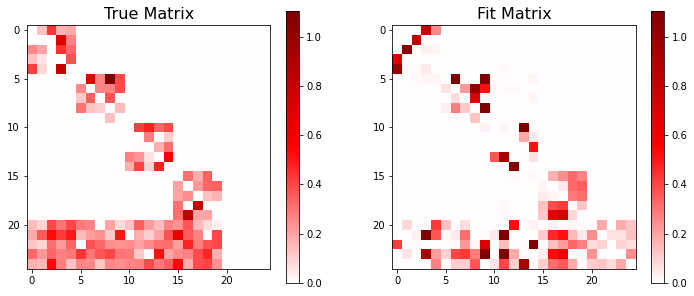

In [4]:
data = ZData.load('../data/allexc/w4bd_25.0.5stim.fitdata')
fit = ZFit.load_fit('../data/allexc/fits/w4bd_25.0.5stim.nuc.fit')
plt.figure(1,(12,5))
plt.subplot(121)
plot_w(data.sim.W,include_colorbar=True)
plt.title('True Matrix',fontsize=16)
plt.subplot(122)
plot_w(fit.W,wmin=np.min(data.sim.W),wmax=np.max(data.sim.W),include_colorbar=True)
plt.title('Fit Matrix',fontsize=16)

In [6]:
sindex = 1
r_pred = fit.generate_prediction(data.firing_rate_estimate[sindex,fit.start_t,:])
rmin = np.min(data.firing_rate_estimate[sindex,:,:])
rmax = np.max(data.firing_rate_estimate[sindex,:,:])
buffer = (rmax - rmin) / 20
plt.figure(1,(15,10))
T = np.shape(data.firing_rate_estimate)[1]
t = np.linspace(0,data.dt_int * (T-1),T)
for i in range(25):
    plt.subplot(5,5,i+1)
    plot_trial(data.firing_rate_estimate[sindex,:,i],fit_rates=r_pred[:,i],t=t)
    plt.ylim(rmin-buffer,rmax+buffer)

NameError: name 'self' is not defined

Text(0, 0.5, 'r^2')

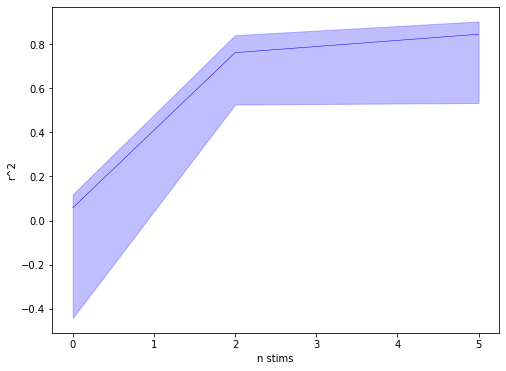

In [7]:
dlist = []
flist = []
for i in range(5):
    dlist.append(ZData.load(f'../data/allexc/w4bd_25.{i}.2stim.fitdata'))
    flist.append(ZFit.load_fit(f'../data/allexc/fits/w4bd_25.{i}.0stim.nuc.fit'))
    for j in [2,5]:
        dlist.append(ZData.load(f'../data/allexc/w4bd_25.{i}.{j}stim.fitdata'))
        flist.append(ZFit.load_fit(f'../data/allexc/fits/w4bd_25.{i}.{j}stim.nuc.fit'))

plt.figure(1,(8,6))
plot_w_err(dlist,flist,y='block-r2',x='nstim',xbins=[0,2,5],color='blue',label='block r2')
plt.xlabel('n stims')
plt.ylabel('r^2')

In [17]:
dlist = []
flist = []
for i in range(5):
    dlist.append(ZData.load(f'../data/allexc/w4bd_25.{i}.20stim.testdata'))
    flist.append(ZFit.load_fit(f'../data/allexc/fits/w4bd_25.{i}.0stim.nuc.fit'))
    for j in [2,5]:
        dlist.append(dlist[i*3])#ZData.load(f'../data/allexc/w4bd_25.{i}.{j}stim.fitdata'))
        flist.append(ZFit.load_fit(f'../data/allexc/fits/w4bd_25.{i}.{j}stim.nuc.fit'))

plt.figure(1,(8,6))
plot_rate_err(dlist,flist,y='pvu',x='nstim',xbins=[0,2,5],color='red',label='\% variance unexplained')
plt.xlabel('n stims')
plt.ylabel('\% variance unexplained')

(21, 94, 25)


NameError: name 'self' is not defined

<Figure size 576x432 with 0 Axes>

Text(0, 0.5, 'overlap')

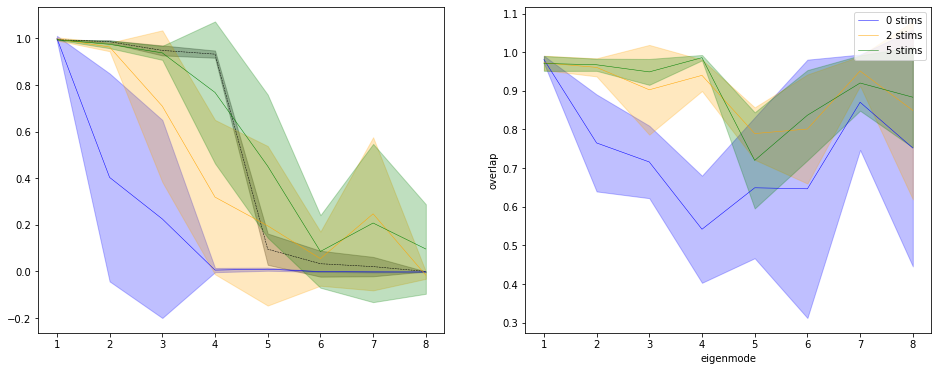

In [23]:
pal = ['blue','orange','green']
next_color = 0
plt.figure(1,(16,6))

vms = []
for i in range(5):
    data = ZData.load(f'../data/allexc/w4bd_25.{i}.2stim.fitdata')
    fit = ZFit.load_fit(f'../data/allexc/fits/w4bd_25.{i}.0stim.nuc.fit')
    vm = match_eigenvectors(data.sim.W,fit.W)
    vms.append(vm)
    
plt.subplot(121)
plot_eigenvalues_real(vms,label='truth',opt='truth')
plot_eigenvalues_real(vms,color=pal[next_color],label=f'0 stims',opt='raw')
plt.subplot(122)
plot_eigenvector_overlap(vms,color=pal[next_color],label=f'0 stims',opt='overlap')
next_color += 1

for j in [2,5]:
    vms = []
    for i in range(5):
        data = ZData.load(f'../data/allexc/w4bd_25.{i}.{j}stim.fitdata')
        fit = ZFit.load_fit(f'../data/allexc/fits/w4bd_25.{i}.{j}stim.nuc.fit')
        vm = match_eigenvectors(data.sim.W,fit.W)
        vms.append(vm)
        
    plt.subplot(121)
    plot_eigenvalues_real(vms,color=pal[next_color],label=f'{j} stims',opt='raw')
    plt.subplot(122)
    plot_eigenvector_overlap(vms,color=pal[next_color],label=f'{j} stims',opt='overlap')
    next_color += 1
    
plt.legend()
plt.xlabel('eigenmode')
plt.ylabel('overlap')